<a href="https://colab.research.google.com/github/emilyj19/TS/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np 
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd

In [16]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/FinancialTS/JPmarket_dataset.npz' 
data = np.load(root_path)

In [18]:
data.files

['train_ratios', 'test_ratios', 'train_volumes', 'test_volumes']

In [0]:
train_ratios = data['train_ratios']
test_ratios = data['test_ratios']
train_vols = data['train_volumes']
test_vols = data['test_volumes']

In [20]:
train_ratios.shape

(499, 462, 64)

In [0]:
#loss function here 
def ModelLoss(actual, pred, N):
  square_loss_matrix = np.square(actual[:,N:] - pred)
  loss = np.mean(np.mean(np.mean(square_loss_matrix, axis = 2), axis = 1))
  return loss

In [0]:
#baseline here 

#moving average 
ratio_pred_MA = np.zeros((499,462-180,64))
for s in range(499):
  #N = 180 days for each prediction so 462 - 180 = 282 preds
  for d in range(180, train_ratios.shape[1]): 
    for t in range(train_ratios.shape[2]): 
      pred_t = np.mean(train_ratios[s,d-180:d,t])
      ratio_pred_MA[s,d-180,t] = pred_t

#generalise this into a function?
      
      
#exponential moving average
#use N = 30 here
ratio_pred_EMA = np.zeros((499,462-30,64))
k = 2/(30+1)
for s in range(499): 
  for d in range(30, train_ratios.shape[1]): 
    for t in range(train_ratios.shape[2]): 
      if (d - 30) == 0: 
        pred_t = np.mean(train_ratios[s,d-30:d,t])
        ratio_pred_EMA[s,d-30,t] = pred_t
      else: 
        pred_t = (1-k)*ratio_pred_EMA[s,d-1-30,t] + k*train_ratios[s,d,t]
        ratio_pred_EMA[s,d-30,t] = pred_t
        

In [0]:
def MovingAverage(data, N):
  no_stocks, days, bins = data.shape
  pred_MA = np.zeros((no_stocks,days-N,bins))
  for s in range(no_stocks):
    for d in range(N, days): 
      for t in range(bins): 
        pred_t = np.mean(train_ratios[s,d-N:d,t])
        pred_MA[s,d-N,t] = pred_t
        
  loss = ModelLoss(data, pred_MA, N)
  
  return pred_MA, loss 

def ExpMovingAverage(data, N): 
  no_stocks, days, bins = data.shape
  pred_EMA = np.zeros((no_stocks,days-N,bins))
  k = 2/(N+1)
  for s in range(no_stocks):
    for d in range(N, days): 
      for t in range(bins): 
        if (d - N) == 0: 
          pred_t = np.mean(data[s,d-N:d,t])
          pred_EMA[s,d-N,t] = pred_t
        else: 
          pred_t = (1-k)*pred_EMA[s,d-1-N,t] + k*data[s,d,t]
          pred_EMA[s,d-N,t] = pred_t
  
  loss = ModelLoss(data, pred_EMA, N)
  
  return pred_EMA, loss 
          

In [23]:
ExpMovingAverage(train_ratios, 30)[1]

0.00017348341437292046

In [24]:
pip install gluonts

In [0]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.util import to_pandas


In [0]:
#split data into new sequences
def split_data(n_days, data): #data for one stock in the form [days, bins]
  no_ts = data.shape[0]-n_days
  length_ts = n_days*data.shape[1]
  new_data = np.zeros((no_ts,length_ts))
  for j in range(no_ts):
    for i in range(n_days): 
      new_data[j,64*i:64*i + 64] = data[j+i,:]
  
  return new_data
  
  

In [0]:
training_data = split_data(180, train_ratios[0])

In [0]:
start = pd.Timestamp("01-01-2019", freq='5min')
prediction_length = 64
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = [{'target': x, 'start': start} for x in training_data[:, :-prediction_length]]
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = [{'target': x, 'start': start} for x in training_data]


In [100]:
estimator = DeepAREstimator(freq = "5min", prediction_length = 64, trainer = Trainer(epochs = 5))
predictor = estimator.train(training_data = train_ds)


I0617 14:13:17.422423 139712634693504 _base.py:188] Start model training
I0617 14:13:17.433330 139712634693504 _base.py:201] Number of parameters in DeepARTrainingNetwork: 13463
I0617 14:13:17.435288 139712634693504 _base.py:242] Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:16<00:00,  3.07it/s, avg_epoch_loss=-2.86]
I0617 14:13:33.710459 139712634693504 _base.py:285] Epoch[0] Elapsed time 16.274 seconds
I0617 14:13:33.718061 139712634693504 _base.py:294] Epoch[0] Evaluation metric 'epoch_loss'=-2.856134
I0617 14:13:33.725958 139712634693504 _base.py:242] Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.16it/s, avg_epoch_loss=-2.94]
I0617 14:13:49.569649 139712634693504 _base.py:285] Epoch[1] Elapsed time 15.843 seconds
I0617 14:13:49.574364 139712634693504 _base.py:294] Epoch[1] Evaluation metric 'epoch_loss'=-2.940110
I0617 14:13:49.582414 139712634693504 _base.py:242] Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:15<00:00,  3.18it/s, 

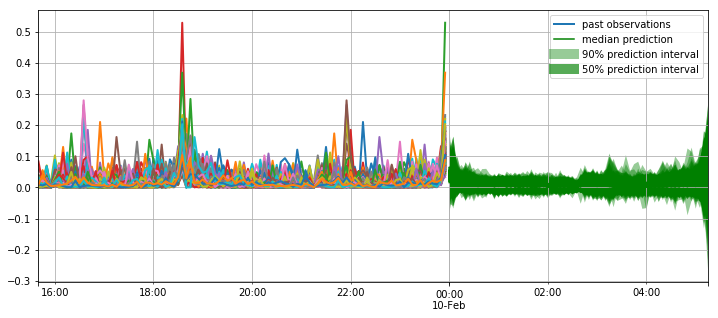

In [88]:
for test_entry, forecast in zip(test_ds, predictor.predict(test_ds)): 
  to_pandas(test_entry)[-100:].plot(figsize=(12,5), linewidth = 2)
  forecast.plot(color='g', prediction_intervals=(50., 90.))
  
plt.grid(which='both')
plt.legend(["past observations", "median prediction", "90% prediction interval", "50% prediction interval"])
plt.show()

In [89]:
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.trainer import Trainer

estimator = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[10],
    prediction_length=64,
    context_length=100,
    freq="5min",
    trainer=Trainer(epochs=5),
)

predictor = estimator.train(train_ds)

I0617 14:09:03.045020 139712634693504 _base.py:188] Start model training
I0617 14:09:03.050747 139712634693504 _base.py:201] Number of parameters in SimpleFeedForwardTrainingNetwork: 643
I0617 14:09:03.052417 139712634693504 _base.py:242] Epoch[0] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 86.84it/s, avg_epoch_loss=-2.4]
I0617 14:09:03.632181 139712634693504 _base.py:285] Epoch[0] Elapsed time 0.579 seconds
I0617 14:09:03.634939 139712634693504 _base.py:294] Epoch[0] Evaluation metric 'epoch_loss'=-2.395792
I0617 14:09:03.642745 139712634693504 _base.py:242] Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 91.44it/s, avg_epoch_loss=-2.71]
I0617 14:09:04.195278 139712634693504 _base.py:285] Epoch[1] Elapsed time 0.550 seconds
I0617 14:09:04.196188 139712634693504 _base.py:294] Epoch[1] Evaluation metric 'epoch_loss'=-2.714148
I0617 14:09:04.205675 139712634693504 _base.py:242] Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [00:00<00:00, 89.89

In [0]:
from gluonts.evaluation.backtest import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_eval_samples=100,  # number of sample paths we want for evaluation
)

In [0]:
forecasts = list(forecast_it)
tss = list(ts_it)

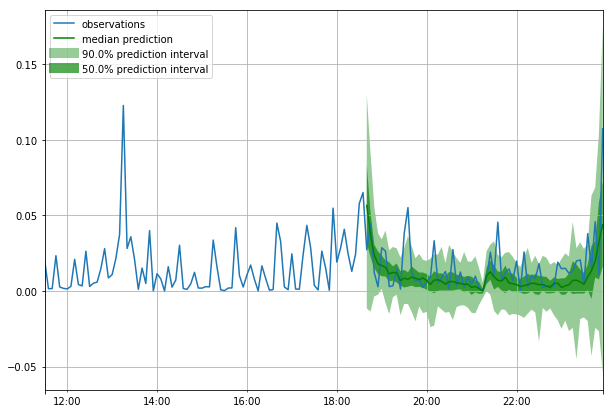

In [103]:
plot_length = 150 
prediction_intervals = (50.0, 90.0)
legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
tss[0][-plot_length:].plot(ax=ax)  # plot the time series
forecasts[0].plot(prediction_intervals=prediction_intervals, color='g')
plt.grid(which="both")
plt.legend(legend, loc="upper left")
plt.show()

In [110]:
forecasts[0]

SampleForecast(array([[ 0.08139747,  0.05372129,  0.05757637, ...,  0.02416272,
        -0.0564222 ,  0.06641157],
       [-0.07482935,  0.02823285,  0.01582822, ...,  0.01840527,
         0.01729212,  0.00257382],
       [ 0.07730628,  0.05118321,  0.03052455, ...,  0.03629315,
         0.0605642 ,  0.06137282],
       ...,
       [ 0.08873064, -0.03424188,  0.02959657, ...,  0.02274878,
         0.06765384,  0.07952201],
       [ 0.05008804,  0.02238055,  0.06015588, ...,  0.01410698,
        -0.00529096,  0.07214031],
       [ 0.06366729,  0.02450472,  0.02661731, ...,  0.10822634,
         0.14416333,  0.0272233 ]], dtype=float32)), Timestamp('2019-02-09 18:40:00', freq='5T'), '5min', item_id=None, info=None)